In [154]:


import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from pathlib import Path

# this makes all plots look nicer, and high dpi
# sn.set_theme(style="whitegrid", font_scale=1.0, rc={"figure.dpi": 200})
# set a nicer font
# plt.rcParams["font.family"] = "serif"
# To set some sane defaults
matplotlib.style.use("fivethirtyeight")
matplotlib.style.use("seaborn-dark-palette")
matplotlib.rcParams["font.family"] = "monospace"
matplotlib.rcParams["figure.dpi"] = 200
matplotlib.rcParams['lines.markersize'] = 10 
plt.rcParams["savefig.facecolor"] = "white"
# sn.set_context("talk")

MODEL_NAMES = {
    0: "stories15M",
    1: "stories42M",
    2: "stories110M",
    # 3: "meta7B",
}

def parse_file(file):
    """
    The data we want to parse has this format:

    # achieved tok/s: (1028.225806). Tokens: (255), seconds: (0.248)
    # dim: 288
    # hidden_dim: 768
    # n_layers: 6
    # n_heads: 6
    # n_kv_heads 6
    # vocab_size 32000
    # seq_length: 256
    """
    with open(file, "r") as f:
        lines = [line.strip() for line in f.readlines()]

    data = {"speed": [], "tokens":[], "seconds":[], "dim": [], "hidden_dim": [], "n_layers":[], "n_heads":[], "n_kv_heads":[], "vocab_size":[], "seq_length":[]}
    pattern = "achieved tok/s: \((.*?)\). Tokens: \((.*?)\), seconds: \((.*?)\)"
    dim = -1
    hidden_dim = -1
    find_match = 0
    generated_string = ""
    for line in lines:
        if r:= re.match(pattern, line):
            find_match = 1
            speed = float(r.group(1))
            tokens = int(r.group(2))
            seconds = float(r.group(3))
            data["speed"] = speed
            data["tokens"] = tokens
            data["seconds"] = seconds
        for param in data.keys():
            
            pattern2 = param + ": \((.*?)\)"
            if r:= re.match(pattern2, line):
                val = int(r.group(1))
                data[param].append(val)
                if param == "dim":
                    dim = val
                elif param == "hidden_dim":
                    hidden_dim = val
                find_match = 1
        if not find_match: 
            generated_string += line
        find_match = 0
    data['kFLOPS'] = calculate_kflop(dim, hidden_dim) 
    return data, generated_string

def calculate_kflop(dim, hidden_dim):
    return 2*dim*hidden_dim*1/1000

def plot(df: pd.DataFrame):
    """
    The dataframe has 3 columns: kernel, size, gflops

    We want to plot the gflops for each kernel, for each size as a single seaborn multi-line plot.
    """
    save_dir = Path.cwd()

    plt.figure(figsize=(18, 10))
    colors = sn.color_palette("flare", len(df["device"].unique()))
    sn.lineplot(data=df, x="kflops", y="speed", hue="device", palette=colors, alpha=0.5, legend=False)
    # also plot points, but without legend
    colors = sn.color_palette("husl", len(df["model"].unique()))
    sn.scatterplot(data=df, x="kflops", y="speed", hue="model", palette=colors, legend="full")

    plt.legend()
    plt.title("Performance on different models")
    plt.xlabel("KFLOPs")
    plt.ylabel("Tokens/s")
    plt.tight_layout()

    plt.savefig(save_dir / "inference_benchmark_results.png")



In [156]:
results_dir = Path("benchmark_results")
assert results_dir.is_dir()
data = []
model_dict = {"stories15M":0 , "stories42M":1 , "stories110M":2}
generated_strings = []
models = []
for filename in results_dir.glob("*.txt"):
    # filenames have the format: <kernel_nr>_output.txt
    if not filename.stem.split("_")[0].isdigit() and "_output" not in filename.stem:
        continue
    results_dict, generated_string = parse_file(filename)
    generated_strings.append(generated_string)
    print(results_dict)
    print(generated_string)
    split_arr = filename.stem.split("_") # gpu, stories15M.bin, output.txt
    # model_size
    device_type = split_arr[0]
    model_nr = split_arr[1].split(".")[0].split('ries')[-1]
    models.append(device_type+model_nr)
    data.append({"device":device_type, "model": device_type + "_" + model_nr, "dim": results_dict["dim"][0], "hidden_dim": results_dict["hidden_dim"][0], "n_layers": results_dict["n_layers"][0], "n_heads": results_dict["n_heads"][0], "n_kv_heads": results_dict["n_kv_heads"][0], "speed": results_dict["speed"], "kflops": results_dict["kFLOPS"], "params":model_nr})
gpu_df = pd.DataFrame(data)
gpu_df

{'speed': 580.865604, 'tokens': 255, 'seconds': 0.439, 'dim': [768], 'hidden_dim': [2048], 'n_layers': [12], 'n_heads': [12], 'n_kv_heads': [12], 'vocab_size': [32000], 'seq_length': [1024], 'kFLOPS': 3145.728}
Once upon a time, there was a little girl named Lily. She loved to play with her toys and run around outside. One day, her mommy asked her to help with the laundry. Lily didn't want to help because she wanted to play, but her mommy said it was important to help out.Lily started to help with the laundry, but she got bored quickly. She started to play with the clothes and throw them around. Her mommy saw what she was doing and got upset. She told Lily that it was not nice to play with the laundry and that she needed to help her.Lily felt bad and knew she had done something wrong. She promised her mommy that she would help with the laundry from now on. Her mommy forgave her and they finished the laundry together. Lily learned that it's important to help out and that being kind is a

,device,model,dim,hidden_dim,n_layers,n_heads,n_kv_heads,speed,kflops,params
0,gpu,gpu_110M,768,2048,12,12,12,580.865604,3145.728,110M
1,gpu,gpu_15M,288,768,6,6,6,1040.816327,442.368,15M
2,gpu,gpu_42M,512,1376,8,8,8,850.000000,1409.024,42M


In [129]:
data = {"device": ["cpu", "cpu","cpu"], "model":["cpu_110M", "cpu_15M", "cpu_42M"], "speed": [45.12, 250.21, 120.91], "dim": [768, 288, 512], "hidden_dim": [2048, 768, 1376], "n_layers":[12, 6, 8], "n_heads":[12, 6, 8], "n_kv_heads":[12, 6, 8], "kflops":[3145.728, 442.368, 1409.024], "params":["110M", "15M", "42M"]}
cpu_df = pd.DataFrame(data)
cpu_df

,device,model,speed,dim,hidden_dim,n_layers,n_heads,n_kv_heads,kflops,params
0,cpu,cpu_110M,45.12,768,2048,12,12,12,3145.728,110M
1,cpu,cpu_15M,250.21,288,768,6,6,6,442.368,15M
2,cpu,cpu_42M,120.91,512,1376,8,8,8,1409.024,42M


In [130]:
df = cpu_df.append(gpu_df)
df

,device,model,speed,dim,hidden_dim,n_layers,n_heads,n_kv_heads,kflops,params
0,cpu,cpu_110M,45.120000,768,2048,12,12,12,3145.728,110M
1,cpu,cpu_15M,250.210000,288,768,6,6,6,442.368,15M
2,cpu,cpu_42M,120.910000,512,1376,8,8,8,1409.024,42M
0,gpu,gpu_110M,580.865604,768,2048,12,12,12,3145.728,110M
1,gpu,gpu_15M,1040.816327,288,768,6,6,6,442.368,15M
2,gpu,gpu_42M,850.000000,512,1376,8,8,8,1409.024,42M


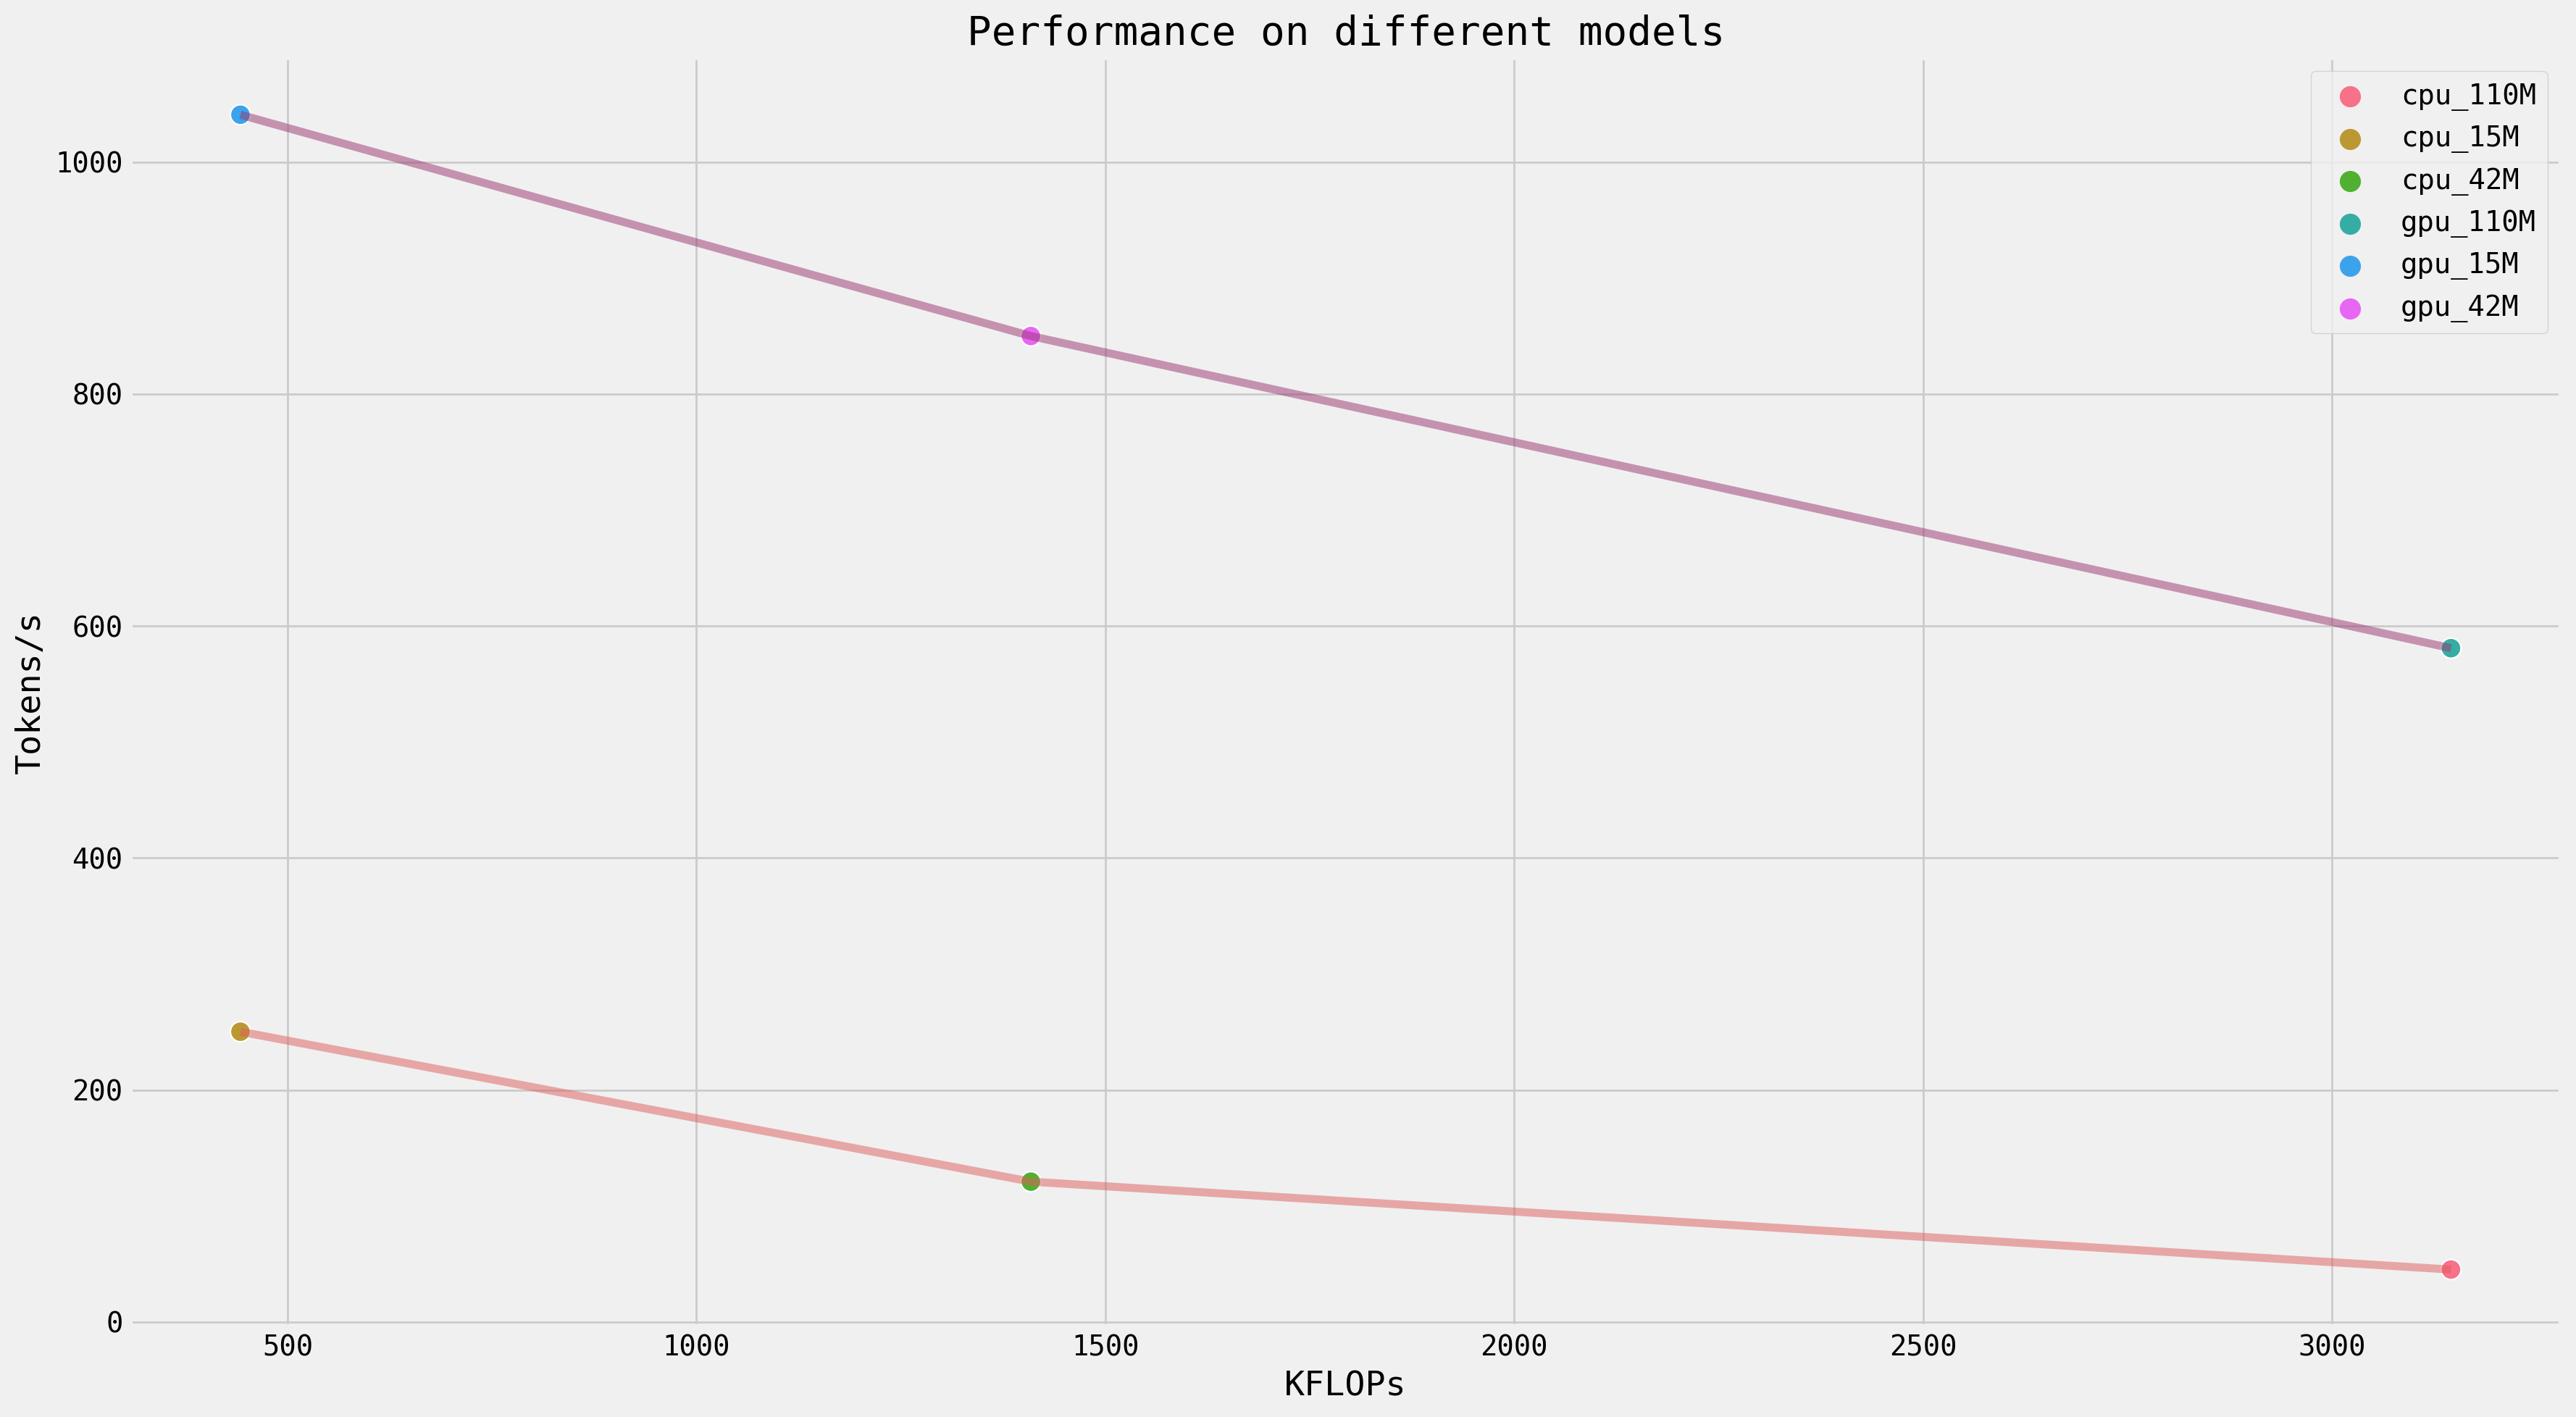

In [148]:
plot(df)

In [157]:
token_dict = {"model":[], "tokens":[]}
for model, gen_token in zip(models, generated_strings):

df_tokens = 

IndentationError: expected an indented block (204637545.py, line 4)

In [149]:
# update the README.md with the new results
with open("README.md", "r") as f:
    readme = f.read()
# delete old results
readme = re.sub(
    r"<!-- inference_benchmark_results -->.*<!-- inference_benchmark_results -->",
    "<!-- inference_benchmark_results -->\n{}\n<!-- inference_benchmark_results -->".format(
        df.to_markdown(index=False)
    ),
    readme,
    flags=re.DOTALL,
)
readme = re.sub(
    r"<!-- inference_token_generation_results -->.*<!-- inference_token_generation_results -->",
    "<!-- inference_token_generation_results -->\n{}\n<!-- inference_token_generation_results -->".format(
        df_tokens.to_markdown(index=False)
    ),
    readme,
    flags=re.DOTALL,

)
# input new results
with open("README.md", "w") as f:
    f.write(readme)
